# Automate XPCS

In [1]:
from globus_automate_client import (create_flows_client, graphviz_format, state_colors_for_log,
                                    get_access_token_for_scope, create_action_client, 
                                    create_flows_client)
from IPython.display import display, display_svg, clear_output
from ipywidgets import widgets
import time
import json
import sys
import os

from funcx.sdk.client import FuncXClient


sys.path.append(".")
os.environ['JUPYTER_PATH'] = '.'
CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"

## funcX

Deine the analysis and plotting functions used in the flow.

In [2]:
fxc = FuncXClient()

In [3]:
login_ep = '6c4323f4-a062-4551-a883-146a352a43f5'
theta_ep = '9f84f41e-dfb6-4633-97be-b46901e9384c'

In [4]:
def alcf_xpcs_corr(event):
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Corr")
    
    hdf_file = event['data']['hdf']
    imm_file = event['data']['imm']
    
    flags = ""
    if "flags" in event['data']:
        flags = event['data']
    
    cmd = f"/soft/datascience/xpcs_eigen/build/corr {hdf_file} -imm {imm_file} {flags}"
    cmd = cmd.strip().split(" ")
    
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE)
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

alcf_xpcs_corr_func_uuid = fxc.register_function(alcf_xpcs_corr, description="An XPCS corr function.")
print(alcf_xpcs_corr_func_uuid)

e53e57d9-e2b0-4d65-9a2b-a37068cede06


In [5]:
def plot_xpcs(event):
    import os
    import time
    import json
    import shutil
    import pickle
    import subprocess
    from subprocess import PIPE
    
    hdf_file = event['data']['hdf']
    hdf_file_name = hdf_file.split("/")[-1]
    exp_name = ".".join(hdf_file.split("/")[-1].split(".")[:-1])
    
    dir_name = "/".join(hdf_file.split('/')[:-1])

    os.chdir(dir_name)
    
    python = '/home/rchard/.conda/envs/funcx-theta/bin/python'
    xpcs_plot = '/home/rchard/src/globus-automation/XPCS/tools/xpcs_plots.py'
    xpcs_meta = '/home/rchard/src/globus-automation/XPCS/tools/xpcs_metadata.py'
    xpcs_qc = '/home/rchard/src/globus-automation/XPCS/tools/xpcs_qc.py'

    cmd = f"{python} {xpcs_plot} {hdf_file}"
    print(cmd)
    cmd = cmd.split(" ")
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE)
    print(res.stdout)
    
    cmd = f"{python} {xpcs_meta} gather {hdf_file}"
    print(cmd)
    
    my_env = os.environ.copy()
    my_env["LC_ALL"] = "C.UTF-8"
    my_env["LANG"] = "C.UTF-8"
    
    cmd = cmd.split(" ")
    res = subprocess.run(cmd, stdout=PIPE, stderr=PIPE, env=my_env)
    print(res.stdout)
    print(res.stderr)

    return cmd
    return 'done'

plot_xpcs_func_uuid = fxc.register_function(plot_xpcs, description="An XPCS corr function.")
print(plot_xpcs_func_uuid)

add04aa4-4275-4532-bb17-4e73981975a9


In [6]:
def alcf_xpcs_pilot(event):
    import os
    import time
    import json
    import subprocess
    from subprocess import PIPE
    from XPCS.tools.xpcs_metadata import gather
    from pilot.client import PilotClient
    from pilot.search import gen_gmeta
    try:
        hdf_file = event['data']['hdf']
        exp_dir = "/".join(event['data']['hdf'].split("/")[:-1])
        exp_name = event['data']['hdf'].split("/")[-1].replace(".hdf", "")

        # Create metadata file
        metadata = gather(hdf_file)
        metadata['title'] = exp_name
        try:
            metadata.pop('exchange.partition_norm_factor')
        except:
            pass

        pc = PilotClient()
        pc.project.current = 'xpcs-8id'

        res = pc.upload(exp_dir, '/', metadata=metadata, dry_run=False, update=True)
    except Exception as e:
        return(f"Failed: {e}")
    
    return 'done'

pilot_func_uuid = fxc.register_function(alcf_xpcs_pilot, description="An XPCS pilot function.")
print(pilot_func_uuid)

b0cbd84f-9670-437a-bd53-2d8119e8099e


## Automate XPCS

Combine using the functions with Automate to first transfer data to Theta, use funcX, then return the result.

In [7]:
flow_definition = {
  "Comment": "Automate XPCS",
  "StartAt": "Transfer1",
  "States": {
    "Transfer1": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer1Input",
      "ResultPath": "$.Transfer1Result",
      "WaitTime": 6000,
      "Next": "ExecCorr"
    },
    "ExecCorr": {
      "Comment": "Use corr to process the data",
      "Type": "Action",
      "ActionUrl": "https://funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec1Input",
      "ResultPath": "$.Exec1Result",
      "WaitTime": 12000,
      "Next": "Transfer2"
    },
    "Transfer2": {
      "Comment": "Initial Transfer from APS to ALCF",
      "Type": "Action",
      "ActionUrl": "https://actions.automate.globus.org/transfer/transfer",
      "ActionScope": "https://auth.globus.org/scopes/actions.globus.org/transfer/transfer",
      "InputPath": "$.Transfer2Input",
      "ResultPath": "$.Transfer2Result",
      "WaitTime": 6000,
      "Next": "ExecPlots"
    },
    "ExecPlots": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec2Input",
      "ResultPath": "$.Exec2Result",
      "WaitTime": 12000,
      "Next": "ExecPilot"
    },
    "ExecPilot": {
      "Comment": "Generate plots from the data",
      "Type": "Action",
      "ActionUrl": "https://funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec3Input",
      "ResultPath": "$.Exec3Result",
      "WaitTime": 12000,
      "End": True
    }
  }
}

In [8]:
flows_client = create_flows_client(CLIENT_ID)
flow = flows_client.deploy_flow(flow_definition, title="XPCS")
from pprint import pprint
pprint(flow)
flow_id = flow.data['id']
print(flow)
flow_scope = flow['globus_auth_scope']
print(f'Newly created flow with id:\n{flow_id}\nand scope:\n{flow_scope}')

GlobusHTTPResponse({'action_url': 'http://flows.automate.globus.org/flows/37488591-c036-4756-8a88-194578d425ba', 'administered_by': [], 'api_version': '1.0', 'definition': {'Comment': 'Automate XPCS', 'StartAt': 'Transfer1', 'States': {'ExecCorr': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://funcx.org/automate', 'Comment': 'Use corr to process the data', 'InputPath': '$.Exec1Input', 'Next': 'Transfer2', 'ResultPath': '$.Exec1Result', 'Type': 'Action', 'WaitTime': 12000}, 'ExecPilot': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://funcx.org/automate', 'Comment': 'Generate plots from the data', 'End': True, 'InputPath': '$.Exec3Input', 'ResultPath': '$.Exec3Result', 'Type': 'Action', 'WaitTime': 12000}, 'ExecPlots': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://funcx.org/a

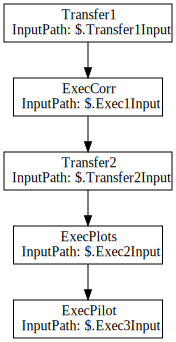

In [9]:
get_resp = flows_client.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

Define a function to serialize inputs for funcX

In [10]:
def serialize_fx_inputs(*args, **kwargs):
    from funcx.serialize import FuncXSerializer
    fx_serializer = FuncXSerializer()
    ser_args = fx_serializer.serialize(args)
    ser_kwargs = fx_serializer.serialize(kwargs)
    payload = fx_serializer.pack_buffers([ser_args, ser_kwargs])
    return payload

In [11]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A001_Aerogel5-4/A001_Aerogel5-4.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A001_Aerogel5-4/A001_Aerogel5-4.imm",
#          "flags": "--rigaku",
     }}
funcx_payload = serialize_fx_inputs(event=event)
# print(funcx_payload)

In [12]:
flow_input = {
  "Transfer1Input": {
    "source_endpoint_id": "fdc7e74a-fa78-11e8-9342-0e3d676669f4",
    "destination_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
    "transfer_items": [
      {
        "source_path": "/data/xpcs8/2019-1/comm201901/cluster_results/A001_Aerogel_1mm_att6_Lq0_001_0001-1000.hdf",
        "destination_path": event['data']['hdf'],
        "recursive": False
      },
      {
        "source_path": "/data/xpcs8/2019-1/comm201901/A001_Aerogel_1mm_att6_Lq0_001/A001_Aerogel_1mm_att6_Lq0_001_00001-01000.imm",
        "destination_path": event['data']['imm'],
        "recursive": False
      }
    ]
  },
  "Exec1Input": {
    "endpoint":theta_ep,
     "func":alcf_xpcs_corr_func_uuid,
     "payload": funcx_payload
  },
  "Exec2Input": {
    "endpoint":theta_ep,
     "func":plot_xpcs_func_uuid,
     "payload": funcx_payload
  },
  "Exec3Input": {
      "endpoint": login_ep,
      "func": pilot_func_uuid,
      "payload": funcx_payload
  },
  "Transfer2Input": {
      "source_endpoint_id": "08925f04-569f-11e7-bef8-22000b9a448b",
      "destination_endpoint_id": "fdc7e74a-fa78-11e8-9342-0e3d676669f4",
      "transfer_items": [
        {
          "source_path": event['data']['hdf'],
          "destination_path": "/data/xpcs8/2019-1/comm201901/ALCF_results/test.hdf",
          "recursive": False
        }
      ]
    }
}


In [13]:
flow_action = flows_client.run_flow(flow_id, flow_scope, flow_input)
print(flow_action)
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']
print(f'Flow action started with id: {flow_action_id}')
while flow_status == 'ACTIVE':
    time.sleep(10)
    flow_action = flows_client.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

Login Here:

https://auth.globus.org/v2/oauth2/authorize?client_id=e6c75d97-532a-4c88-b031-8584a319fa3e&redirect_uri=https%3A%2F%2Fauth.globus.org%2Fv2%2Fweb%2Fauth-code&scope=https%3A%2F%2Fauth.globus.org%2Fscopes%2F37488591-c036-4756-8a88-194578d425ba%2Fflow_37488591_c036_4756_8a88_194578d425ba&state=_default&response_type=code&code_challenge=6l0a-8QHV2u0sILdbX6rxcjbsb4-xKFipTDu3fKyPGc&code_challenge_method=S256&access_type=offline&prefill_named_grant=Globus+Automate+Client


Note that this link can only be used once! If login or a later step in the flow fails, you must restart it.
Enter resulting code:lDK9PhhAleNxFjf9mRFosVKZSw5GEO
GlobusHTTPResponse({'action_id': '5e32009f-697e-44ca-9561-b8acc7ba712e', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:c4765424-d274-11e5-b894-cb4139f74ecf', 'details': {'code': 'ActionStarted', 'description': 'State Transfer1 of type Action started', 'details': {'input': {'Exec1Input': {'endpoint': '9f84f41e-dfb6-4633-97be-b46901e938

KeyboardInterrupt: 

In [19]:
# Values to paste into the kickoff and wait scripts

# funcX Endpoints
print(f"""# funcX endpoints
FUNCX_THETA_ENDPOINT = "{theta_ep}"
FUNCX_LOGIN_ENDPOINT = "{login_ep}"

# funcX functions
FUNCX_CORR_FUNCID = "{alcf_xpcs_corr_func_uuid}"
FUNCX_PLOT_FUNCID = "{plot_xpcs_func_uuid}"
FUNCX_PILOT_FUNCID = "{pilot_func_uuid}"

# flow details
FLOW_ID = "{flow_id}"
FLOW_SCOPE = "{flow_scope}\"""")


# funcX endpoints
FUNCX_THETA_ENDPOINT = "9f84f41e-dfb6-4633-97be-b46901e9384c"
FUNCX_LOGIN_ENDPOINT = "6c4323f4-a062-4551-a883-146a352a43f5"

# funcX functions
FUNCX_CORR_FUNCID = "e53e57d9-e2b0-4d65-9a2b-a37068cede06"
FUNCX_PLOT_FUNCID = "add04aa4-4275-4532-bb17-4e73981975a9"
FUNCX_PILOT_FUNCID = "b0cbd84f-9670-437a-bd53-2d8119e8099e"

# flow details
FLOW_ID = "37488591-c036-4756-8a88-194578d425ba"
FLOW_SCOPE = "https://auth.globus.org/scopes/37488591-c036-4756-8a88-194578d425ba/flow_37488591_c036_4756_8a88_194578d425ba"


# Testing

In [32]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A001_Aerogel5-2/A001_Aerogel5-2.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A001_Aerogel5-2/A001_Aerogel5-2.imm",
     }}

res = fxc.run(event, endpoint_id=theta_ep, function_id=plot_xpcs_func_uuid)
# res = fxc.run(event, endpoint_id=login_ep, function_id=pilot_func_uuid)

In [33]:
# event = {"data": {
#          "hdf": "/projects/APSDataAnalysis/Automate/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400.hdf",
#          "imm": "/projects/APSDataAnalysis/Automate/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_00001-00400.imm",
# #          "flags": "--rigaku",     
#          "metadata": "/projects/APSDataAnalysis/Automate/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400/A010_MJ_PMA_47g136kDa_att2_180C_Lq0_002_0002-0400.json"      
#      }}

In [34]:
# res = fxc.run(event, endpoint_id=login_ep, function_id=p)

In [35]:
res

'156f680b-3bee-4b1f-853d-f2226b31987b'

In [36]:
fxc.get_result(res)

Exception: Task pending

### Testing Pilot ingest

Need to figure out either using -s or renaming the directory the data is being processed in. Perhaps easiest if we just force everything to be worked on in the experiment name dir? then do a chdir to that exp?

In [34]:
def alcf_xpcs_pilot(event):
    import os
    import time
    import json
    import subprocess
    from subprocess import PIPE
    
    print("Starting XPCS Pilot")
    
    meta_file = event['data']['metadata']
    exp_dir = "/".join(event['data']['hdf'].split("/")[:-1])
    exp_name = event['data']['hdf'].split("/")[-1].replace(".hdf", "")
    
    os.chdir(exp_dir)
    
    pilot = '/home/rchard/.conda/envs/funcx-theta/bin/pilot'

    cmd = f"{pilot} upload -u -j {meta_file} {exp_name} /"
    print(cmd)
    return cmd
    res = subprocess.run(cmd.split(" "), stdout=PIPE, stderr=PIPE,
    env={'LC_ALL': 'C.UTF-8', 'LANG': 'C.UTF-8'})
    
    print(res.stdout)
    print(res.stderr)
    return str(res.stdout)

pilot_func_uuid = fxc.register_function(alcf_xpcs_pilot, description="An XPCS pilot function.")
print(pilot_func_uuid)

4f63f171-a154-4a02-98a1-3d27551017a4


In [79]:
event = {"data": {
         "hdf": "/projects/APSDataAnalysis/Automate/A047_test_001_0001-0256/A047_test_001_0001-0256.hdf",
         "imm": "/projects/APSDataAnalysis/Automate/A047_test_001_0001-0256/A047_test_001_00001-00256.imm",
         "metadata": "/projects/APSDataAnalysis/Automate/A047_test_001_0001-0256/A047_test_001_0001-0256.json"
     }}
res = fxc.run(event, endpoint_id=login_ep, function_id=pilot_func_uuid)
print(res)

8ef2d684-3fb6-4beb-864b-876051e94dd9


In [82]:
print(fxc.get_result(res))

Exception: Task pending

In [39]:
from funcx.serialize import FuncXSerializer
fx_serializer = FuncXSerializer()
res = """1706
04
gANYCQAAAHBsb3RfeHBjc3EAWM4EAABkZWYgcGxvdF94cGNzKGV2ZW50KToKICAgIGltcG9ydCBvcwogICAgaW1wb3J0IHRpbWUKICAgIGltcG9ydCBqc29uCiAgICBpbXBvcnQgc2h1dGlsCiAgICBpbXBvcnQgcGlja2xlCiAgICBpbXBvcnQgc3VicHJvY2VzcwogICAgZnJvbSBzdWJwcm9jZXNzIGltcG9ydCBQSVBFCiAgICAKICAgIGhkZl9maWxlID0gZXZlbnRbJ2RhdGEnXVsnaGRmJ10KICAgIGhkZl9maWxlX25hbWUgPSBoZGZfZmlsZS5zcGxpdCgiLyIpWy0xXQogICAgZXhwX25hbWUgPSAiLiIuam9pbihoZGZfZmlsZS5zcGxpdCgiLyIpWy0xXS5zcGxpdCgiLiIpWzotMV0pCiAgICAKICAgIGRpcl9uYW1lID0gIi8iLmpvaW4oaGRmX2ZpbGUuc3BsaXQoJy8nKVs6LTFdKQoKICAgIG9zLmNoZGlyKGRpcl9uYW1lKQogICAgCiAgICBweXRob24gPSAnL2hvbWUvcmNoYXJkLy5jb25kYS9lbnZzL2Z1bmN4LXRoZXRhL2Jpbi9weXRob24nCiAgICB4cGNzX3Bsb3QgPSAnL2hvbWUvcmNoYXJkL0FQU0RhdGFBbmFseXNpcy90b29scy9waWxvdDEtdG9vbHMvc2NyaXB0cy94cGNzX3Bsb3RzLnB5JwogICAgeHBjc19tZXRhID0gJy9ob21lL3JjaGFyZC9BUFNEYXRhQW5hbHlzaXMvdG9vbHMvcGlsb3QxLXRvb2xzL3NjcmlwdHMveHBjc19tZXRhZGF0YS5weScKICAgIHhwY3NfcWMgPSAnL2hvbWUvcmNoYXJkL0FQU0RhdGFBbmFseXNpcy90b29scy9waWxvdDEtdG9vbHMvc2NyaXB0cy94cGNzX3FjLnB5JwoKICAgIGNtZCA9IGYie3B5dGhvbn0ge3hwY3NfcGxvdH0ge2hkZl9maWxlfSIKICAgIHByaW50KGNtZCkKICAgIGNtZCA9IGNtZC5zcGxpdCgiICIpCiAgICByZXMgPSBzdWJwcm9jZXNzLnJ1bihjbWQsIHN0ZG91dD1QSVBFLCBzdGRlcnI9UElQRSkKICAgIHByaW50KHJlcy5zdGRvdXQpCiAgICAKICAgIGNtZCA9IGYie3B5dGhvbn0ge3hwY3NfbWV0YX0gZ2F0aGVyIHtoZGZfZmlsZX0iCiAgICBwcmludChjbWQpCiAgICAKICAgIG15X2VudiA9IG9zLmVudmlyb24uY29weSgpCiAgICBteV9lbnZbIkxDX0FMTCJdID0gIkMuVVRGLTgiCiAgICBteV9lbnZbIkxBTkciXSA9ICJDLlVURi04IgogICAgCiAgICBjbWQgPSBjbWQuc3BsaXQoIiAiKQogICAgcmVzID0gc3VicHJvY2Vzcy5ydW4oY21kLCBzdGRvdXQ9UElQRSwgc3RkZXJyPVBJUEUsIGVudj1teV9lbnYpCiAgICBwcmludChyZXMuc3Rkb3V0KQogICAgcHJpbnQocmVzLnN0ZGVycikgCgogICAgcmV0dXJuIGNtZAogICAgcmV0dXJuICdkb25lJwpxAYZxAi4="""

x = fx_serializer.deserialize(res)
x


Exception: Invalid header: 170 in data payload

In [40]:
fx_serializer.unpack_and_deserialize(res)


AssertionError: Unpack expects 3 buffers, got 1

### Nick testing

In [ ]:
def process_hdf(event):
    import os
    import shutil
    from XPCS.scripts.xpcs_metadata import gather
    from XPCS.scripts.xpcs_plots import make_plots
    from XPCS.scripts.xpcs_qc import check_hdf_dataset
    from pilot.client import PilotClient

    hdf_file = event['data']['hdf']
    hdf_dir, extension = os.path.splitext(hdf_file)
    try:
        os.mkdir(hdf_dir)
        shutil.move(hdf_file, hdf_dir)
    except Exception as e:
        print(e)
    hdf_file = os.path.join(hdf_dir, os.path.basename(hdf_file))
    os.chdir(hdf_dir)
    assert os.path.exists(hdf_file), 'HDF File {hdf_file} does not exist!'

    if check_hdf_dataset(hdf_file) is False:
        print('HDF Check failed, skipping...')
        return {}
    metadata = gather(hdf_file)
    make_plots(hdf_file)
    metadata.update(event['custom_metadata'])
    pc = PilotClient()
    uploaded_metadata = pc.register(hdf_dir, '/', metadata=metadata,
                                    update=True, skip_analysis=True)
    print('Everything worked, register called')
    return uploaded_metadata

In [ ]:
process_hdf_func_uuid = fxc.register_function(
    process_hdf, description="Put hdf file into dir, make plots, gather metadata."
)
print(process_hdf_func_uuid)

In [ ]:
fname = '/Users/nick/globus/aps/globus-automation/XPCS/data/A001_Aerogel_1mm_att3_Lq0_001_0001-1000.hdf'
payload = {
    'data': {
        "hdf": f"{fname}"
    },
    'custom_metadata': {
        "description": f"{fname}: Automated data processing.",
        "creators": [{"creatorName": "8-ID"}],
        "publisher": "Automate",
        "title": fname,
        "subjects": [{"subject": "XPCS"}, {"subject": "8-ID"}],
        "publicationYear": "2019",
        "resourceType": {
            "resourceType": "Dataset",
            "resourceTypeGeneral": "Dataset"
        }
    }
}
res = fxc.run(payload, endpoint_id=local_ep, function_id=process_hdf_func_uuid)
print(res)

In [ ]:
print(res)
fxc.get_result(res)